# Imports

In [2]:
import pandas as pd
import re
import os


import nltk
# Download necessary NLTK data to the specific directory
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer

[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1006)>
[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1006)>
[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1006)>


# Strategies

This notebook aims to test several basic models for binary classification. We will start by preprocessing tweets like we did during the EDA (URLs, mentions, hashtags,...), then tokens will be vectorized using either BoW or TF-IDF. Then, we will compare basic machine learning models using MLflow to mesure performances of each model and ease the comparison.

**Models to test:**
- Linear regression - Simple yet effective linear model for binary classification. Works great with bag-of-words or TF-IDF features. Outputs probabilities, which are useful for threshold tuning.
- Random Forest Classifier - Can capture non-linear word interactions without manual feature engineering. Easy to interpret (at least for shallow trees).
- SVM - Very fast and efficient for text (especially with sparse, high-dimensional data). Based on word occurrence probabilities, which often work surprisingly well in text classification. Robust even with relatively small datasets.
- Naive bayes - Very fast and efficient for text (especially with sparse, high-dimensional data). Based on word occurrence probabilities, which often work surprisingly well in text classification. Robust even with relatively small datasets.

**Metrics :**
- Accuracy for an overall performance check
- Precision (positive predicted values / true positives)
- Recall 
- F1-score

# Data and preparation

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', True)

In [4]:
path = "../data/training.1600000.processed.noemoticon.csv"
# Load the data from the CSV file into a pandas DataFrame
data = pd.read_csv(path,
                header=None,
                names=["target", "ids", "date", "flag", "user", "text"],
                usecols=["target", "ids", "date", "user", "text"],  # remove flag column
                parse_dates=["date"],
                encoding="utf-8",
                encoding_errors="replace",)

# Display the first few rows of the DataFrame and its info
display(data.head())
print(f'Shape of the DataFrame: {data.shape}')

print(f"Number of unique target values: {data['target'].value_counts()}")
# Change target value 4 to 1
data['target'] = data['target'].replace(4, 1)
print(f"Number of unique target values after replacement: {data['target'].value_counts()}")

/var/folders/5n/5_6qtt550_3dxz3f8y6wwjww0000gn/T/ipykernel_40185/4236509596.py:3: FutureWarning: Parsed string "Mon Apr 06 22:19:45 PDT 2009" included an un-recognized timezone "PDT". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  data = pd.read_csv(path,


,target,ids,date,user,text
0,0,1467810369,2009-04-06 22:19:45,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,2009-04-06 22:19:49,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,2009-04-06 22:19:53,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,2009-04-06 22:19:57,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,2009-04-06 22:19:57,Karoli,"@nationwideclass no, it's not behaving at all...."


Shape of the DataFrame: (1600000, 5)
Number of unique target values: target
0    800000
4    800000
Name: count, dtype: int64
Number of unique target values after replacement: target
0    800000
1    800000
Name: count, dtype: int64


## Preprocessing

In [5]:
def process_text(text, lemmatize=False, stemming=False):
    """
    Cleans and preprocesses a single text string by replacing URLs, mentions, and hashtags,
    converting to lowercase, removing special characters, and removing stopwords.

    Args:
        text (str): The text string to process.

    Returns:
        str: The processed text string.
    """


    if pd.isna(text):
        return ""
    # Replace URLs with <URL>
    processed = re.sub(r'https?://\S+', '<URL>', text)
    # Replace mentions with <MENTION>
    processed = re.sub(r'@[A-Za-z0-9_]+', '<MENTION>', processed)
    # Separate # from word and replace the word with <HASHTAG>
    processed = re.sub(r'#([A-Za-z0-9_]+)', r'#<HASHTAG>', processed)

    # Convert text to lowercase
    processed = processed.lower()

    # Remove special characters and numbers, keeping !, ?, and ellipsis (...)
    # Also keeps the placeholders <URL>, <MENTION>, <HASHTAG>
    processed = re.sub(r'[^a-z0-9\s.!?<>#]', '', processed)

    # Tokenize the text
    tokens = word_tokenize(processed)

    if stemming and lemmatize:
        raise ValueError("Cannot use both stemming and lemmatization at the same time. Choose one.")

    # Initialize lemmatizer
    if lemmatize:
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(token) for token in tokens] if lemmatize else tokens

    # Initialize stemmer
    if stemming:
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(token) for token in tokens] if stemming else tokens


    # Define negative words that should not be removed
    negative_words = {
        'no', 'not', 'nor', "don't", "aren't", "couldn't", "didn't", "doesn't",
        "hadn't", "hasn't", "haven't", "isn't", "mightn't", "mustn't",
        "needn't", "shan't", "shouldn't", "wasn't", "weren't", "won't", "wouldn't",
        "never", "none", "nobody", "nothing", "nowhere", "neither"
    }
    # Create a set of stopwords to remove, excluding the negative words
    stop_words_to_remove = set(stopwords.words('english')) - negative_words

    # remove stopwords, and join back to string
    filtered_tokens = [word for word in tokens if word not in stop_words_to_remove]

    return ' '.join(filtered_tokens)


In [6]:
# Sample dataframe for each target
negative_sample = data[data['target'] == 0].sample(n=25000, random_state=42)
positive_sample = data[data['target'] == 1].sample(n=25000, random_state=42)
# Concatenate the two samples
sample_df = pd.concat([negative_sample, positive_sample], ignore_index=True)
# Apply the process_text function to the 'text' column
nltk.download('punkt_tab')
sample_df['processed_text_lem'] = sample_df['text'].apply(process_text, lemmatize=True)
sample_df['processed_text_stem'] = sample_df['text'].apply(process_text, stemming=True)

# Display the first few rows of the processed DataFrame
display(sample_df.tail())
print(f'Shape of the processed DataFrame: {sample_df.shape}')


[nltk_data] Error loading punkt_tab: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1006)>


,target,ids,date,user,text,processed_text_lem,processed_text_stem
49995,1,2185646565,2009-06-15 17:41:41,nazbear,@abcdude I'll bet your plane takes off to the ...,< mention > ill bet plane take tune quotill al...,< mention > ill bet plane take tune quotil alr...
49996,1,1556812170,2009-04-19 00:28:02,digmyshine,Gaaah just got some good news about day 26!!!!,gaaah got good news day 26 ! ! ! !,gaaah got good news day 26 ! ! ! !
49997,1,1994848543,2009-06-01 12:33:13,TerezBaskin,"Salad: chicken, craisins, carrots, mushrooms, ...",salad chicken craisins carrot mushroom cheese ...,salad chicken craisin carrot mushroom chees ba...
49998,1,2068458420,2009-06-07 14:06:50,TidalWaves7,Chillin on a raft in Devin's pool.,chillin raft devins pool .,chillin raft devin pool .
49999,1,2056840796,2009-06-06 11:53:42,krpearce,I think it's about time for a spontaneous trip...,think time spontaneous trip home visit amazing...,think time spontan trip home visit amaz famili...


Shape of the processed DataFrame: (50000, 7)


## Split data to train and test sets

In [7]:
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
X_lem = sample_df['processed_text_lem']
y_lem = sample_df['target']

X_stem = sample_df['processed_text_stem']
y_stem = sample_df['target']

# Split the data into training and testing sets
X_train_lem, X_test_lem, y_train_lem, y_test_lem = train_test_split(
    X_lem, y_lem,
    test_size=0.2,
    random_state=42,
    stratify=y_lem
)

# Display the shapes of the resulting datasets
print(f"X_train_lem shape: {X_train_lem.shape}")
print(f"X_test_lem shape: {X_test_lem.shape}")
print(f"y_train_lem shape: {y_train_lem.shape}")
print(f"y_test_lem shape: {y_test_lem.shape}")

# Split the data into training and testing sets
X_train_stem, X_test_stem, y_train_stem, y_test_stem = train_test_split(
    X_stem, y_stem,
    test_size=0.2,
    random_state=42,
    stratify=y_stem
)

# Display the shapes of the resulting datasets
print(f"X_train_stem shape: {X_train_stem.shape}")
print(f"X_test_stem shape: {X_test_stem.shape}")
print(f"y_train_stem shape: {y_train_stem.shape}")
print(f"y_test_stem shape: {y_test_stem.shape}")

X_train_shape = X_train_lem.shape
X_test_shape = X_test_lem.shape

X_train_lem shape: (40000,)
X_test_lem shape: (10000,)
y_train_lem shape: (40000,)
y_test_lem shape: (10000,)
X_train_stem shape: (40000,)
X_test_stem shape: (10000,)
y_train_stem shape: (40000,)
y_test_stem shape: (10000,)


# Configuring MLflow

In [30]:
import os
from dotenv import load_dotenv
import time
import pickle

import mlflow
from mlflow.models import infer_signature
from mlflow.tracking import MlflowClient


from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix,fbeta_score, roc_curve, classification_report, make_scorer, matthews_corrcoef, balanced_accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV, cross_val_score

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm


# For scikit-learn
mlflow.sklearn.autolog()

# Configuring MLflow
load_dotenv()
tracking_uri = os.getenv("MLFLOW_TRACKING_URI")
mlflow.set_tracking_uri(tracking_uri)
print(f"MLflow Tracking URI: {tracking_uri}")

MLflow Tracking URI: http://localhost:8080


In [31]:
# Create a new MLflow Experiment
mlflow.set_experiment("P7-Sentiments_Analysis")

<Experiment: artifact_location='mlflow-artifacts:/582216974290491259', creation_time=1756644597023, experiment_id='582216974290491259', last_update_time=1756644597023, lifecycle_stage='active', name='P7-Sentiments_Analysis', tags={}>

## Evaluation function

In [22]:
def evaluate_model(model, X_test, y_test, model_name, vectorizer_name):
    """
    Evaluates a machine learning model using various metrics and visualizations.
    Args:
        model: The trained machine learning model to evaluate.
        X_test: The test features.
        y_test: The true labels for the test set.
        model_name: The name of the model being evaluated.
        vectorizer_name: The name of the vectorizer used for feature extraction.
    Returns:
        accuracy, precision, recall, f1, f05, f2, roc_auc: Evaluation metrics.
        fig_cm: Figure of the confusion matrix.
        fig_roc: Figure of the ROC curve.
        y_pred: Predicted labels for the test set.
    """
    # Predict the labels for the test set
    y_pred = model.predict(X_test)

    # Get the predicted probabilities or decision function scores
    if hasattr(model, 'predict_proba'):
        y_score = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, 'decision_function'):
        y_score = model.decision_function(X_test)
    else:
        y_score = y_pred  # Fallback for models without probability estimates

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_score)

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    fig_cm, ax_cm = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax_cm)
    ax_cm.set_xlabel('Prediction')
    ax_cm.set_ylabel('Real label')
    ax_cm.set_title(f'Confusion matrix - {model_name} with {vectorizer_name}')

    # Créer la courbe ROC
    fpr, tpr, _ = roc_curve(y_test, y_score)
    fig_roc, ax_roc = plt.subplots(figsize=(8, 6))
    ax_roc.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
    ax_roc.plot([0, 1], [0, 1], 'k--')
    ax_roc.set_xlim([0.0, 1.0])
    ax_roc.set_ylim([0.0, 1.05])
    ax_roc.set_xlabel('False Positive Rate')
    ax_roc.set_ylabel('True Positive Rate')
    ax_roc.set_title(f'ROC curve - {model_name} with {vectorizer_name}')
    ax_roc.legend(loc="lower right")
    ax_roc.grid(True)

    # Afficher les résultats
    print(f"\nResults for {model_name} with {vectorizer_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print("\nConfusion matrix:")
    print(cm)
    print("\nClassificatin report:")
    print(classification_report(y_test, y_pred))

    return accuracy, precision, recall, specificity, roc_auc, fig_cm, fig_roc, y_pred

## Instantiate the vectorizers

In [11]:
# Instantiate the vectorizers
tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
bow_vectorizer = CountVectorizer(max_features=10000, ngram_range=(1, 2))


# Vectorize texts into TF-IDF vectors
X_train_tfidf_lem = tfidf_vectorizer.fit_transform(X_train_lem)
X_test_tfidf_lem = tfidf_vectorizer.transform(X_test_lem)
X_train_tfidf_stem = tfidf_vectorizer.fit_transform(X_train_stem)
X_test_tfidf_stem = tfidf_vectorizer.transform(X_test_stem)

# Vectorize texts into Bag-of-Words vectors
X_train_bow_lem = bow_vectorizer.fit_transform(X_train_lem)
X_test_bow_lem = bow_vectorizer.transform(X_test_lem)
X_train_bow_stem = bow_vectorizer.fit_transform(X_train_stem)
X_test_bow_stem = bow_vectorizer.transform(X_test_stem)

## Instanciate models

In [23]:
# Instanciate the models
base_models = {
    "Logistic_Regression": LogisticRegression(random_state=42),
    "SVM_Lineaire": LinearSVC(random_state=42),
    "Random_Forest": RandomForestClassifier(random_state=42),
    "Naive_Bayes": MultinomialNB()
}

# Defined hyperparameters
param_grids = {
    "Logistic_Regression": {
        'C': [0.01, 0.1, 1.0, 10.0],
        'max_iter': [1000],
        'solver': ['liblinear', 'saga']
    },
    "SVM_Lineaire": {
        'C': [0.01, 0.1, 1.0, 10.0],
        'max_iter': [1000],
        'dual': [True, False]
    },
    "Random_Forest": {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5]
    },
    "Naive_Bayes": {
        'alpha': [0.1, 0.5, 1.0, 2.0]
    }
}

# Vectorizers
vectorizers = {
    "TF-IDF_lem": (tfidf_vectorizer, X_train_tfidf_lem, X_test_tfidf_lem, y_train_lem, y_test_lem),
    "BoW_lem": (bow_vectorizer, X_train_bow_lem, X_test_bow_lem, y_train_lem, y_test_lem),
    "TF-IDF_stem": (tfidf_vectorizer, X_train_tfidf_stem, X_test_tfidf_stem, y_train_stem, y_test_stem),
    "BoW_stem": (bow_vectorizer, X_train_bow_stem, X_test_bow_stem, y_train_stem, y_test_stem),
}

# Scorers
scorers = {
    'specificity': make_scorer(recall_score, pos_label=0),
    'mcc': make_scorer(matthews_corrcoef),
    'balanced_acc': make_scorer(balanced_accuracy_score)
}

## Training

In [32]:
train_models = True  # Set to True to train models
if train_models:

    # Total iterations for the progress bar
    total_iterations = len(base_models) * len(vectorizers)
    progress_bar = tqdm(total=total_iterations, desc="Overall Progress")

    results = []

    # Test each model with the two types of vectorization
    for model_name, base_model in base_models.items():
        for vectorizer_name, (vectorizer, X_train_vec, X_test_vec, y_train_vec, y_test_vec) in vectorizers.items():
            print(f"\n{'='*80}")
            print(f"Starting training for {model_name} with {vectorizer_name}...")

            # Start MLflow run
            with mlflow.start_run(run_name=f"Basic_Model_{model_name}_{vectorizer_name}"):
                # Log parameters
                mlflow.log_param("model_type", model_name)
                mlflow.log_param("vectorizer_type", vectorizer_name)
                mlflow.log_param("dataset_size", X_train_shape[0] + X_test_shape[0])
                mlflow.log_param("train_size", X_train_shape[0])
                mlflow.log_param("test_size", X_test_shape[0])
                mlflow.log_param("max_features", 10000)
                mlflow.log_param("ngram_range", "(1, 2)")

                # Initialize the timer
                start_time = time.time()

                # Train the model
                base_model.fit(X_train_vec, y_train_vec)

                # Training time
                training_time = time.time() - start_time

                # Log the training time
                mlflow.log_metric("training_time", training_time)

                # Evaluate the best model on the test set
                acc, prec, rec, specificity, roc_auc, fig_cm, fig_roc, y_pred = evaluate_model(
                    base_model, X_test_vec, y_test_vec, model_name, vectorizer_name
                )

                # Log metrics
                mlflow.log_metric("accuracy", acc)
                mlflow.log_metric("precision", prec)
                mlflow.log_metric("recall", rec)
                mlflow.log_metric("specificity", specificity)
                mlflow.log_metric("roc_auc", roc_auc)

                # Log confusion matrix and ROC curve figures
                mlflow.log_figure(fig_cm, "confusion_matrix.png")
                mlflow.log_figure(fig_roc, "roc_curve.png")
                plt.close(fig_cm)
                plt.close(fig_roc)

                # Log the model
                signature = infer_signature(X_train_vec, y_pred)
                mlflow.sklearn.log_model(base_model, "model", signature=signature)

                # Save the model artifacts into a specific directory
                os.makedirs("./content/basic-model", exist_ok=True)

                # Save and log the vectorizer
                vectorizer_path = f"./content/basic-model/vectorizer_{vectorizer_name}.pkl"
                with open(vectorizer_path, "wb") as f:
                    pickle.dump(vectorizer, f)
                mlflow.log_artifact(vectorizer_path)

                # Save the results in a list
                results.append({
                    "Model": model_name.replace("_", " "),
                    "Vectorization": vectorizer_name,
                    "Accuracy": acc,
                    "Precision": prec,
                    "Recall": rec,
                    "ROC AUC": roc_auc,
                    "Training time (s)": training_time
                })

                # Display the results
                print(f"Accuracy: {acc:.4f}")
                print(f"Specificity: {specificity:.4f}")
                print(f"ROC AUC test: {roc_auc:.4f}")
                print(f"Training time: {training_time:.2f} secondes")


            # Update the progress bar
            progress_bar.update(1)
            progress_bar.set_description(f"Last model: {model_name} with {vectorizer_name}")

    progress_bar.close()

Overall Progress:   0%|          | 0/16 [00:00<?, ?it/s]


Starting training for Logistic_Regression with TF-IDF_lem...


2025/09/05 14:55:10 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/09/05 14:55:15 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Results for Logistic_Regression with TF-IDF_lem:
Accuracy: 0.7718
Precision: 0.7691
Recall: 0.7768
Specificity: 0.7668
ROC AUC: 0.8535

Confusion matrix:
[[3834 1166]
 [1116 3884]]

Classificatin report:
              precision    recall  f1-score   support

           0       0.77      0.77      0.77      5000
           1       0.77      0.78      0.77      5000

    accuracy                           0.77     10000
   macro avg       0.77      0.77      0.77     10000
weighted avg       0.77      0.77      0.77     10000



Last model: Logistic_Regression with TF-IDF_lem:   6%|▋         | 1/16 [00:08<02:11,  8.75s/it]

Accuracy: 0.7718
Specificity: 0.7668
ROC AUC test: 0.8535
Training time: 6.17 secondes
🏃 View run Basic_Model_Logistic_Regression_TF-IDF_lem at: http://localhost:8080/#/experiments/582216974290491259/runs/4e1ddcf0ce6a40e8bff0d7545b206f1a
🧪 View experiment at: http://localhost:8080/#/experiments/582216974290491259

Starting training for Logistic_Regression with BoW_lem...


2025/09/05 14:55:19 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/09/05 14:55:34 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Results for Logistic_Regression with BoW_lem:
Accuracy: 0.7663
Precision: 0.7611
Recall: 0.7762
Specificity: 0.7564
ROC AUC: 0.8406

Confusion matrix:
[[3782 1218]
 [1119 3881]]

Classificatin report:
              precision    recall  f1-score   support

           0       0.77      0.76      0.76      5000
           1       0.76      0.78      0.77      5000

    accuracy                           0.77     10000
   macro avg       0.77      0.77      0.77     10000
weighted avg       0.77      0.77      0.77     10000



Last model: Logistic_Regression with BoW_lem:  12%|█▎        | 2/16 [00:29<03:40, 15.74s/it]   

Accuracy: 0.7663
Specificity: 0.7564
ROC AUC test: 0.8406
Training time: 14.95 secondes
🏃 View run Basic_Model_Logistic_Regression_BoW_lem at: http://localhost:8080/#/experiments/582216974290491259/runs/c0e292478a2a46339c38d59ad9736043
🧪 View experiment at: http://localhost:8080/#/experiments/582216974290491259

Starting training for Logistic_Regression with TF-IDF_stem...


2025/09/05 14:55:40 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/09/05 14:55:46 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Results for Logistic_Regression with TF-IDF_stem:
Accuracy: 0.7725
Precision: 0.7727
Recall: 0.7722
Specificity: 0.7728
ROC AUC: 0.8546

Confusion matrix:
[[3864 1136]
 [1139 3861]]

Classificatin report:
              precision    recall  f1-score   support

           0       0.77      0.77      0.77      5000
           1       0.77      0.77      0.77      5000

    accuracy                           0.77     10000
   macro avg       0.77      0.77      0.77     10000
weighted avg       0.77      0.77      0.77     10000



Last model: Logistic_Regression with TF-IDF_stem:  19%|█▉        | 3/16 [00:40<02:55, 13.51s/it]

Accuracy: 0.7725
Specificity: 0.7728
ROC AUC test: 0.8546
Training time: 7.12 secondes
🏃 View run Basic_Model_Logistic_Regression_TF-IDF_stem at: http://localhost:8080/#/experiments/582216974290491259/runs/be21c0fdbdf04958bc51705230568b39
🧪 View experiment at: http://localhost:8080/#/experiments/582216974290491259

Starting training for Logistic_Regression with BoW_stem...


2025/09/05 14:55:51 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/09/05 14:55:56 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Results for Logistic_Regression with BoW_stem:
Accuracy: 0.7688
Precision: 0.7643
Recall: 0.7774
Specificity: 0.7602
ROC AUC: 0.8399

Confusion matrix:
[[3801 1199]
 [1113 3887]]

Classificatin report:
              precision    recall  f1-score   support

           0       0.77      0.76      0.77      5000
           1       0.76      0.78      0.77      5000

    accuracy                           0.77     10000
   macro avg       0.77      0.77      0.77     10000
weighted avg       0.77      0.77      0.77     10000



Last model: Logistic_Regression with BoW_stem:  25%|██▌       | 4/16 [00:49<02:23, 11.99s/it]   

Accuracy: 0.7688
Specificity: 0.7602
ROC AUC test: 0.8399
Training time: 6.57 secondes
🏃 View run Basic_Model_Logistic_Regression_BoW_stem at: http://localhost:8080/#/experiments/582216974290491259/runs/a2cc70b4d8c341918971fd96aca181d1
🧪 View experiment at: http://localhost:8080/#/experiments/582216974290491259

Starting training for SVM_Lineaire with TF-IDF_lem...


2025/09/05 14:56:00 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/09/05 14:56:05 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Results for SVM_Lineaire with TF-IDF_lem:
Accuracy: 0.7618
Precision: 0.7603
Recall: 0.7646
Specificity: 0.7590
ROC AUC: 0.8389

Confusion matrix:
[[3795 1205]
 [1177 3823]]

Classificatin report:
              precision    recall  f1-score   support

           0       0.76      0.76      0.76      5000
           1       0.76      0.76      0.76      5000

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.76     10000
weighted avg       0.76      0.76      0.76     10000



Last model: SVM_Lineaire with TF-IDF_lem:  31%|███▏      | 5/16 [00:58<01:58, 10.74s/it]     

Accuracy: 0.7618
Specificity: 0.7590
ROC AUC test: 0.8389
Training time: 6.09 secondes
🏃 View run Basic_Model_SVM_Lineaire_TF-IDF_lem at: http://localhost:8080/#/experiments/582216974290491259/runs/7e70955902554dd18819c0e3eff18654
🧪 View experiment at: http://localhost:8080/#/experiments/582216974290491259

Starting training for SVM_Lineaire with BoW_lem...


2025/09/05 14:56:08 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/09/05 14:56:12 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Results for SVM_Lineaire with BoW_lem:
Accuracy: 0.7493
Precision: 0.7454
Recall: 0.7572
Specificity: 0.7414
ROC AUC: 0.8143

Confusion matrix:
[[3707 1293]
 [1214 3786]]

Classificatin report:
              precision    recall  f1-score   support

           0       0.75      0.74      0.75      5000
           1       0.75      0.76      0.75      5000

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



Last model: SVM_Lineaire with BoW_lem:  38%|███▊      | 6/16 [01:06<01:36,  9.68s/it]   

Accuracy: 0.7493
Specificity: 0.7414
ROC AUC test: 0.8143
Training time: 5.54 secondes
🏃 View run Basic_Model_SVM_Lineaire_BoW_lem at: http://localhost:8080/#/experiments/582216974290491259/runs/51b069d4f5ee466c9625e0a8e4609de9
🧪 View experiment at: http://localhost:8080/#/experiments/582216974290491259

Starting training for SVM_Lineaire with TF-IDF_stem...


2025/09/05 14:56:16 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/09/05 14:56:20 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Results for SVM_Lineaire with TF-IDF_stem:
Accuracy: 0.7602
Precision: 0.7590
Recall: 0.7626
Specificity: 0.7578
ROC AUC: 0.8387

Confusion matrix:
[[3789 1211]
 [1187 3813]]

Classificatin report:
              precision    recall  f1-score   support

           0       0.76      0.76      0.76      5000
           1       0.76      0.76      0.76      5000

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.76     10000
weighted avg       0.76      0.76      0.76     10000



Last model: SVM_Lineaire with TF-IDF_stem:  44%|████▍     | 7/16 [01:13<01:21,  9.07s/it]

Accuracy: 0.7602
Specificity: 0.7578
ROC AUC test: 0.8387
Training time: 5.61 secondes
🏃 View run Basic_Model_SVM_Lineaire_TF-IDF_stem at: http://localhost:8080/#/experiments/582216974290491259/runs/c88d9c4e1e0a4c8fae51244012405284
🧪 View experiment at: http://localhost:8080/#/experiments/582216974290491259

Starting training for SVM_Lineaire with BoW_stem...


2025/09/05 14:56:24 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/09/05 14:56:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Results for SVM_Lineaire with BoW_stem:
Accuracy: 0.7424
Precision: 0.7392
Recall: 0.7490
Specificity: 0.7358
ROC AUC: 0.8092

Confusion matrix:
[[3679 1321]
 [1255 3745]]

Classificatin report:
              precision    recall  f1-score   support

           0       0.75      0.74      0.74      5000
           1       0.74      0.75      0.74      5000

    accuracy                           0.74     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.74      0.74      0.74     10000



Last model: SVM_Lineaire with BoW_stem:  50%|█████     | 8/16 [01:22<01:10,  8.83s/it]   

Accuracy: 0.7424
Specificity: 0.7358
ROC AUC test: 0.8092
Training time: 6.09 secondes
🏃 View run Basic_Model_SVM_Lineaire_BoW_stem at: http://localhost:8080/#/experiments/582216974290491259/runs/a9228eb4f9fa4f52aa99d580a2298a34
🧪 View experiment at: http://localhost:8080/#/experiments/582216974290491259

Starting training for Random_Forest with TF-IDF_lem...


2025/09/05 14:56:32 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/09/05 15:00:39 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID f34cd6e98f1646e399aeb36950ec1599. Failed operations: [MlflowException("API request to http://localhost:8080/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=8080): Max retries exceeded with url: /api/2.0/mlflow/runs/log-batch (Caused by ResponseError(\'too many 500 error responses\'))")]')]



Results for Random_Forest with TF-IDF_lem:
Accuracy: 0.7503
Precision: 0.7508
Recall: 0.7494
Specificity: 0.7512
ROC AUC: 0.8277

Confusion matrix:
[[3756 1244]
 [1253 3747]]

Classificatin report:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75      5000
           1       0.75      0.75      0.75      5000

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



2025/09/05 15:00:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
Last model: Random_Forest with TF-IDF_lem:  56%|█████▋    | 9/16 [05:36<09:59, 85.67s/it]

Accuracy: 0.7503
Specificity: 0.7512
ROC AUC test: 0.8277
Training time: 249.07 secondes
🏃 View run Basic_Model_Random_Forest_TF-IDF_lem at: http://localhost:8080/#/experiments/582216974290491259/runs/f34cd6e98f1646e399aeb36950ec1599
🧪 View experiment at: http://localhost:8080/#/experiments/582216974290491259

Starting training for Random_Forest with BoW_lem...


2025/09/05 15:00:47 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/09/05 15:04:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 8e958c0a3d49472b8ad128459d5510a3. Failed operations: [MlflowException("API request to http://localhost:8080/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=8080): Max retries exceeded with url: /api/2.0/mlflow/runs/log-batch (Caused by ResponseError(\'too many 500 error responses\'))")]')]
2025/09/05 15:04:56 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Results for Random_Forest with BoW_lem:
Accuracy: 0.7477
Precision: 0.7544
Recall: 0.7346
Specificity: 0.7608
ROC AUC: 0.8255

Confusion matrix:
[[3804 1196]
 [1327 3673]]

Classificatin report:
              precision    recall  f1-score   support

           0       0.74      0.76      0.75      5000
           1       0.75      0.73      0.74      5000

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



Last model: Random_Forest with BoW_lem:  62%|██████▎   | 10/16 [09:51<13:47, 137.84s/it]   

Accuracy: 0.7477
Specificity: 0.7608
ROC AUC test: 0.8255
Training time: 249.21 secondes
🏃 View run Basic_Model_Random_Forest_BoW_lem at: http://localhost:8080/#/experiments/582216974290491259/runs/8e958c0a3d49472b8ad128459d5510a3
🧪 View experiment at: http://localhost:8080/#/experiments/582216974290491259

Starting training for Random_Forest with TF-IDF_stem...


2025/09/05 15:05:01 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/09/05 15:09:08 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 395afeb1516c4d818e7a4add4ff6e8cc. Failed operations: [MlflowException("API request to http://localhost:8080/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=8080): Max retries exceeded with url: /api/2.0/mlflow/runs/log-batch (Caused by ResponseError(\'too many 500 error responses\'))")]')]



Results for Random_Forest with TF-IDF_stem:
Accuracy: 0.7522
Precision: 0.7555
Recall: 0.7458
Specificity: 0.7586
ROC AUC: 0.8317

Confusion matrix:
[[3793 1207]
 [1271 3729]]

Classificatin report:
              precision    recall  f1-score   support

           0       0.75      0.76      0.75      5000
           1       0.76      0.75      0.75      5000

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



2025/09/05 15:09:10 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
Last model: Random_Forest with TF-IDF_stem:  69%|██████▉   | 11/16 [14:17<14:45, 177.15s/it]

Accuracy: 0.7522
Specificity: 0.7586
ROC AUC test: 0.8317
Training time: 248.77 secondes
🏃 View run Basic_Model_Random_Forest_TF-IDF_stem at: http://localhost:8080/#/experiments/582216974290491259/runs/395afeb1516c4d818e7a4add4ff6e8cc
🧪 View experiment at: http://localhost:8080/#/experiments/582216974290491259

Starting training for Random_Forest with BoW_stem...


2025/09/05 15:09:31 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/09/05 15:13:37 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 071bf3b8980b4c27bca8a36eb305fb20. Failed operations: [MlflowException("API request to http://localhost:8080/api/2.0/mlflow/runs/log-batch failed with exception HTTPConnectionPool(host=\'localhost\', port=8080): Max retries exceeded with url: /api/2.0/mlflow/runs/log-batch (Caused by ResponseError(\'too many 500 error responses\'))")]')]
2025/09/05 15:13:39 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Results for Random_Forest with BoW_stem:
Accuracy: 0.7498
Precision: 0.7604
Recall: 0.7294
Specificity: 0.7702
ROC AUC: 0.8285

Confusion matrix:
[[3851 1149]
 [1353 3647]]

Classificatin report:
              precision    recall  f1-score   support

           0       0.74      0.77      0.75      5000
           1       0.76      0.73      0.74      5000

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



Last model: Random_Forest with BoW_stem:  75%|███████▌  | 12/16 [18:35<13:26, 201.53s/it]   

Accuracy: 0.7498
Specificity: 0.7702
ROC AUC test: 0.8285
Training time: 251.11 secondes
🏃 View run Basic_Model_Random_Forest_BoW_stem at: http://localhost:8080/#/experiments/582216974290491259/runs/071bf3b8980b4c27bca8a36eb305fb20
🧪 View experiment at: http://localhost:8080/#/experiments/582216974290491259

Starting training for Naive_Bayes with TF-IDF_lem...


2025/09/05 15:13:45 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/09/05 15:13:50 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Results for Naive_Bayes with TF-IDF_lem:
Accuracy: 0.7597
Precision: 0.7683
Recall: 0.7436
Specificity: 0.7758
ROC AUC: 0.8427

Confusion matrix:
[[3879 1121]
 [1282 3718]]

Classificatin report:
              precision    recall  f1-score   support

           0       0.75      0.78      0.76      5000
           1       0.77      0.74      0.76      5000

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.76     10000
weighted avg       0.76      0.76      0.76     10000



Last model: Naive_Bayes with TF-IDF_lem:  81%|████████▏ | 13/16 [18:43<07:09, 143.09s/it]

Accuracy: 0.7597
Specificity: 0.7758
ROC AUC test: 0.8427
Training time: 5.43 secondes
🏃 View run Basic_Model_Naive_Bayes_TF-IDF_lem at: http://localhost:8080/#/experiments/582216974290491259/runs/028086739302428f87f7de6193227ab8
🧪 View experiment at: http://localhost:8080/#/experiments/582216974290491259

Starting training for Naive_Bayes with BoW_lem...


2025/09/05 15:13:53 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/09/05 15:13:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Results for Naive_Bayes with BoW_lem:
Accuracy: 0.7609
Precision: 0.7685
Recall: 0.7468
Specificity: 0.7750
ROC AUC: 0.8346

Confusion matrix:
[[3875 1125]
 [1266 3734]]

Classificatin report:
              precision    recall  f1-score   support

           0       0.75      0.78      0.76      5000
           1       0.77      0.75      0.76      5000

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.76     10000
weighted avg       0.76      0.76      0.76     10000



Last model: Naive_Bayes with BoW_lem:  88%|████████▊ | 14/16 [18:52<03:24, 102.43s/it]   

Accuracy: 0.7609
Specificity: 0.7750
ROC AUC test: 0.8346
Training time: 5.66 secondes
🏃 View run Basic_Model_Naive_Bayes_BoW_lem at: http://localhost:8080/#/experiments/582216974290491259/runs/56aa04db25e845c9b1dcc991a748535c
🧪 View experiment at: http://localhost:8080/#/experiments/582216974290491259

Starting training for Naive_Bayes with TF-IDF_stem...


2025/09/05 15:14:02 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/09/05 15:14:07 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Results for Naive_Bayes with TF-IDF_stem:
Accuracy: 0.7579
Precision: 0.7684
Recall: 0.7384
Specificity: 0.7774
ROC AUC: 0.8430

Confusion matrix:
[[3887 1113]
 [1308 3692]]

Classificatin report:
              precision    recall  f1-score   support

           0       0.75      0.78      0.76      5000
           1       0.77      0.74      0.75      5000

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.76     10000
weighted avg       0.76      0.76      0.76     10000



Last model: Naive_Bayes with TF-IDF_stem:  94%|█████████▍| 15/16 [19:00<01:13, 73.96s/it]

Accuracy: 0.7579
Specificity: 0.7774
ROC AUC test: 0.8430
Training time: 5.74 secondes
🏃 View run Basic_Model_Naive_Bayes_TF-IDF_stem at: http://localhost:8080/#/experiments/582216974290491259/runs/8a2b3e5bfec64fc5ad461f2e56b5ddb2
🧪 View experiment at: http://localhost:8080/#/experiments/582216974290491259

Starting training for Naive_Bayes with BoW_stem...


2025/09/05 15:14:10 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/09/05 15:14:15 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Results for Naive_Bayes with BoW_stem:
Accuracy: 0.7602
Precision: 0.7684
Recall: 0.7450
Specificity: 0.7754
ROC AUC: 0.8356

Confusion matrix:
[[3877 1123]
 [1275 3725]]

Classificatin report:
              precision    recall  f1-score   support

           0       0.75      0.78      0.76      5000
           1       0.77      0.74      0.76      5000

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.76     10000
weighted avg       0.76      0.76      0.76     10000



Last model: Naive_Bayes with BoW_stem: 100%|██████████| 16/16 [19:09<00:00, 71.81s/it]   

Accuracy: 0.7602
Specificity: 0.7754
ROC AUC test: 0.8356
Training time: 6.24 secondes
🏃 View run Basic_Model_Naive_Bayes_BoW_stem at: http://localhost:8080/#/experiments/582216974290491259/runs/bd8d8b21bfbd493e9fe7f5c38808b15b
🧪 View experiment at: http://localhost:8080/#/experiments/582216974290491259


## Evaluation

In [27]:
# Get mlflow results
def get_mlflow_results(experiment_name:str ="P7-Sentiments_Analysis", run_name: str = "Basic_Model", uri: str = None):
    """
    Retrieves the results of the MLflow runs for the basic models.
    Args:
        experiment_name (str): The name of the MLflow experiment to search in.
        run_name (str): The name of the runs to filter by.
        uri (str): Optional; the URI of the MLflow tracking server. If None, uses the default tracking URI.
    Returns:
        pd.DataFrame: A DataFrame containing the results of the MLflow runs.
    """
    # Connect to the MLflow tracking server
    if uri:
        mlflow.set_tracking_uri(uri)

    # Create mlflow client
    client = MlflowClient()

    # Get the experiment ID by name
    try:
        experiment = client.get_experiment_by_name(experiment_name)
        if not experiment:
            raise ValueError(f"Experiment '{experiment_name}' not found.")
        experiment_id = experiment.experiment_id
    except Exception as e:
        print(f"Error retrieving experiment '{experiment_name}': {experiment}")
        return pd.DataFrame()

    # Load the MLflow runs
    runs = client.search_runs(experiment_ids=[experiment_id],
                            filter_string=f"tags.mlflow.runName LIKE '%{run_name}%'",
                            order_by=["metrics.specificity DESC"])

    # Store results in a list
    results = []

    for run in runs:
        # Get run name
        run_name = run.data.tags.get("mlflow.runName", "")

        # Get model type and vectorization type
        model_type = run.data.params.get("model_type", "")
        vectorization_type = run.data.params.get("vectorizer_type", "")

        # Rename model
        model_type = model_type.replace("_", " ")

        # Get metrics
        metrics = run.data.metrics

        results.append({
            "Run Name": run_name,
            "Model": model_type,
            "Vectorization": vectorization_type,
            "Accuracy": metrics.get("accuracy", None),
            "Precision": metrics.get("precision", None),
            "Recall": metrics.get("recall", None),
            "Specificity": metrics.get("specificity", None),
            "ROC AUC": metrics.get("roc_auc", None),
            "Training Time (s)": metrics.get("training_time", None)
        })

    results_df = pd.DataFrame(results)
    if not results_df.empty and "Specificity" in results_df.columns:
        results_df = results_df.sort_values(by="Specificity", ascending=False)
        results_df.reset_index(drop=True, inplace=True)

    return results_df

In [33]:
results_df = get_mlflow_results(experiment_name="P7-Sentiments_Analysis", run_name="Basic_Model_", uri=tracking_uri)

In [34]:
display(results_df)

,Run Name,Model,Vectorization,Accuracy,Precision,Recall,Specificity,ROC AUC,Training Time (s)
0,Basic_Model_Naive_Bayes_TF-IDF_stem,Naive Bayes,TF-IDF_stem,0.7579,0.768366,0.7384,0.7774,0.843038,5.739339
1,Basic_Model_Naive_Bayes_TF-IDF_stem,Naive Bayes,TF-IDF_stem,0.7579,0.768366,0.7384,0.7774,0.843038,5.383470
2,Basic_Model_Naive_Bayes_TF-IDF_lem,Naive Bayes,TF-IDF_lem,0.7597,0.768341,0.7436,0.7758,0.842707,5.431446
3,Basic_Model_Naive_Bayes_TF-IDF_lem,Naive Bayes,TF-IDF_lem,0.7597,0.768341,0.7436,0.7758,0.842707,6.308797
4,Basic_Model_Naive_Bayes_BoW_stem,Naive Bayes,BoW_stem,0.7602,0.768358,0.7450,0.7754,0.835599,6.238217
...,...,...,...,...,...,...,...,...,...
61,Basic_Model_SVM_Lineaire_TF-IDF_lem,SVM Lineaire,TF-IDF_lem,0.7724,0.769170,0.7784,NaN,0.853643,9.764943
62,Basic_Model_Logistic_Regression_BoW_stem,Logistic Regression,BoW_stem,0.7721,0.764843,0.7858,NaN,0.845166,18.741481
63,Basic_Model_Logistic_Regression_TF-IDF_stem,Logistic Regression,TF-IDF_stem,0.7724,0.772182,0.7728,NaN,0.854628,7.784519
64,Basic_Model_Logistic_Regression_BoW_lem,Logistic Regression,BoW_lem,0.7682,0.760895,0.7822,NaN,0.843118,19.771128


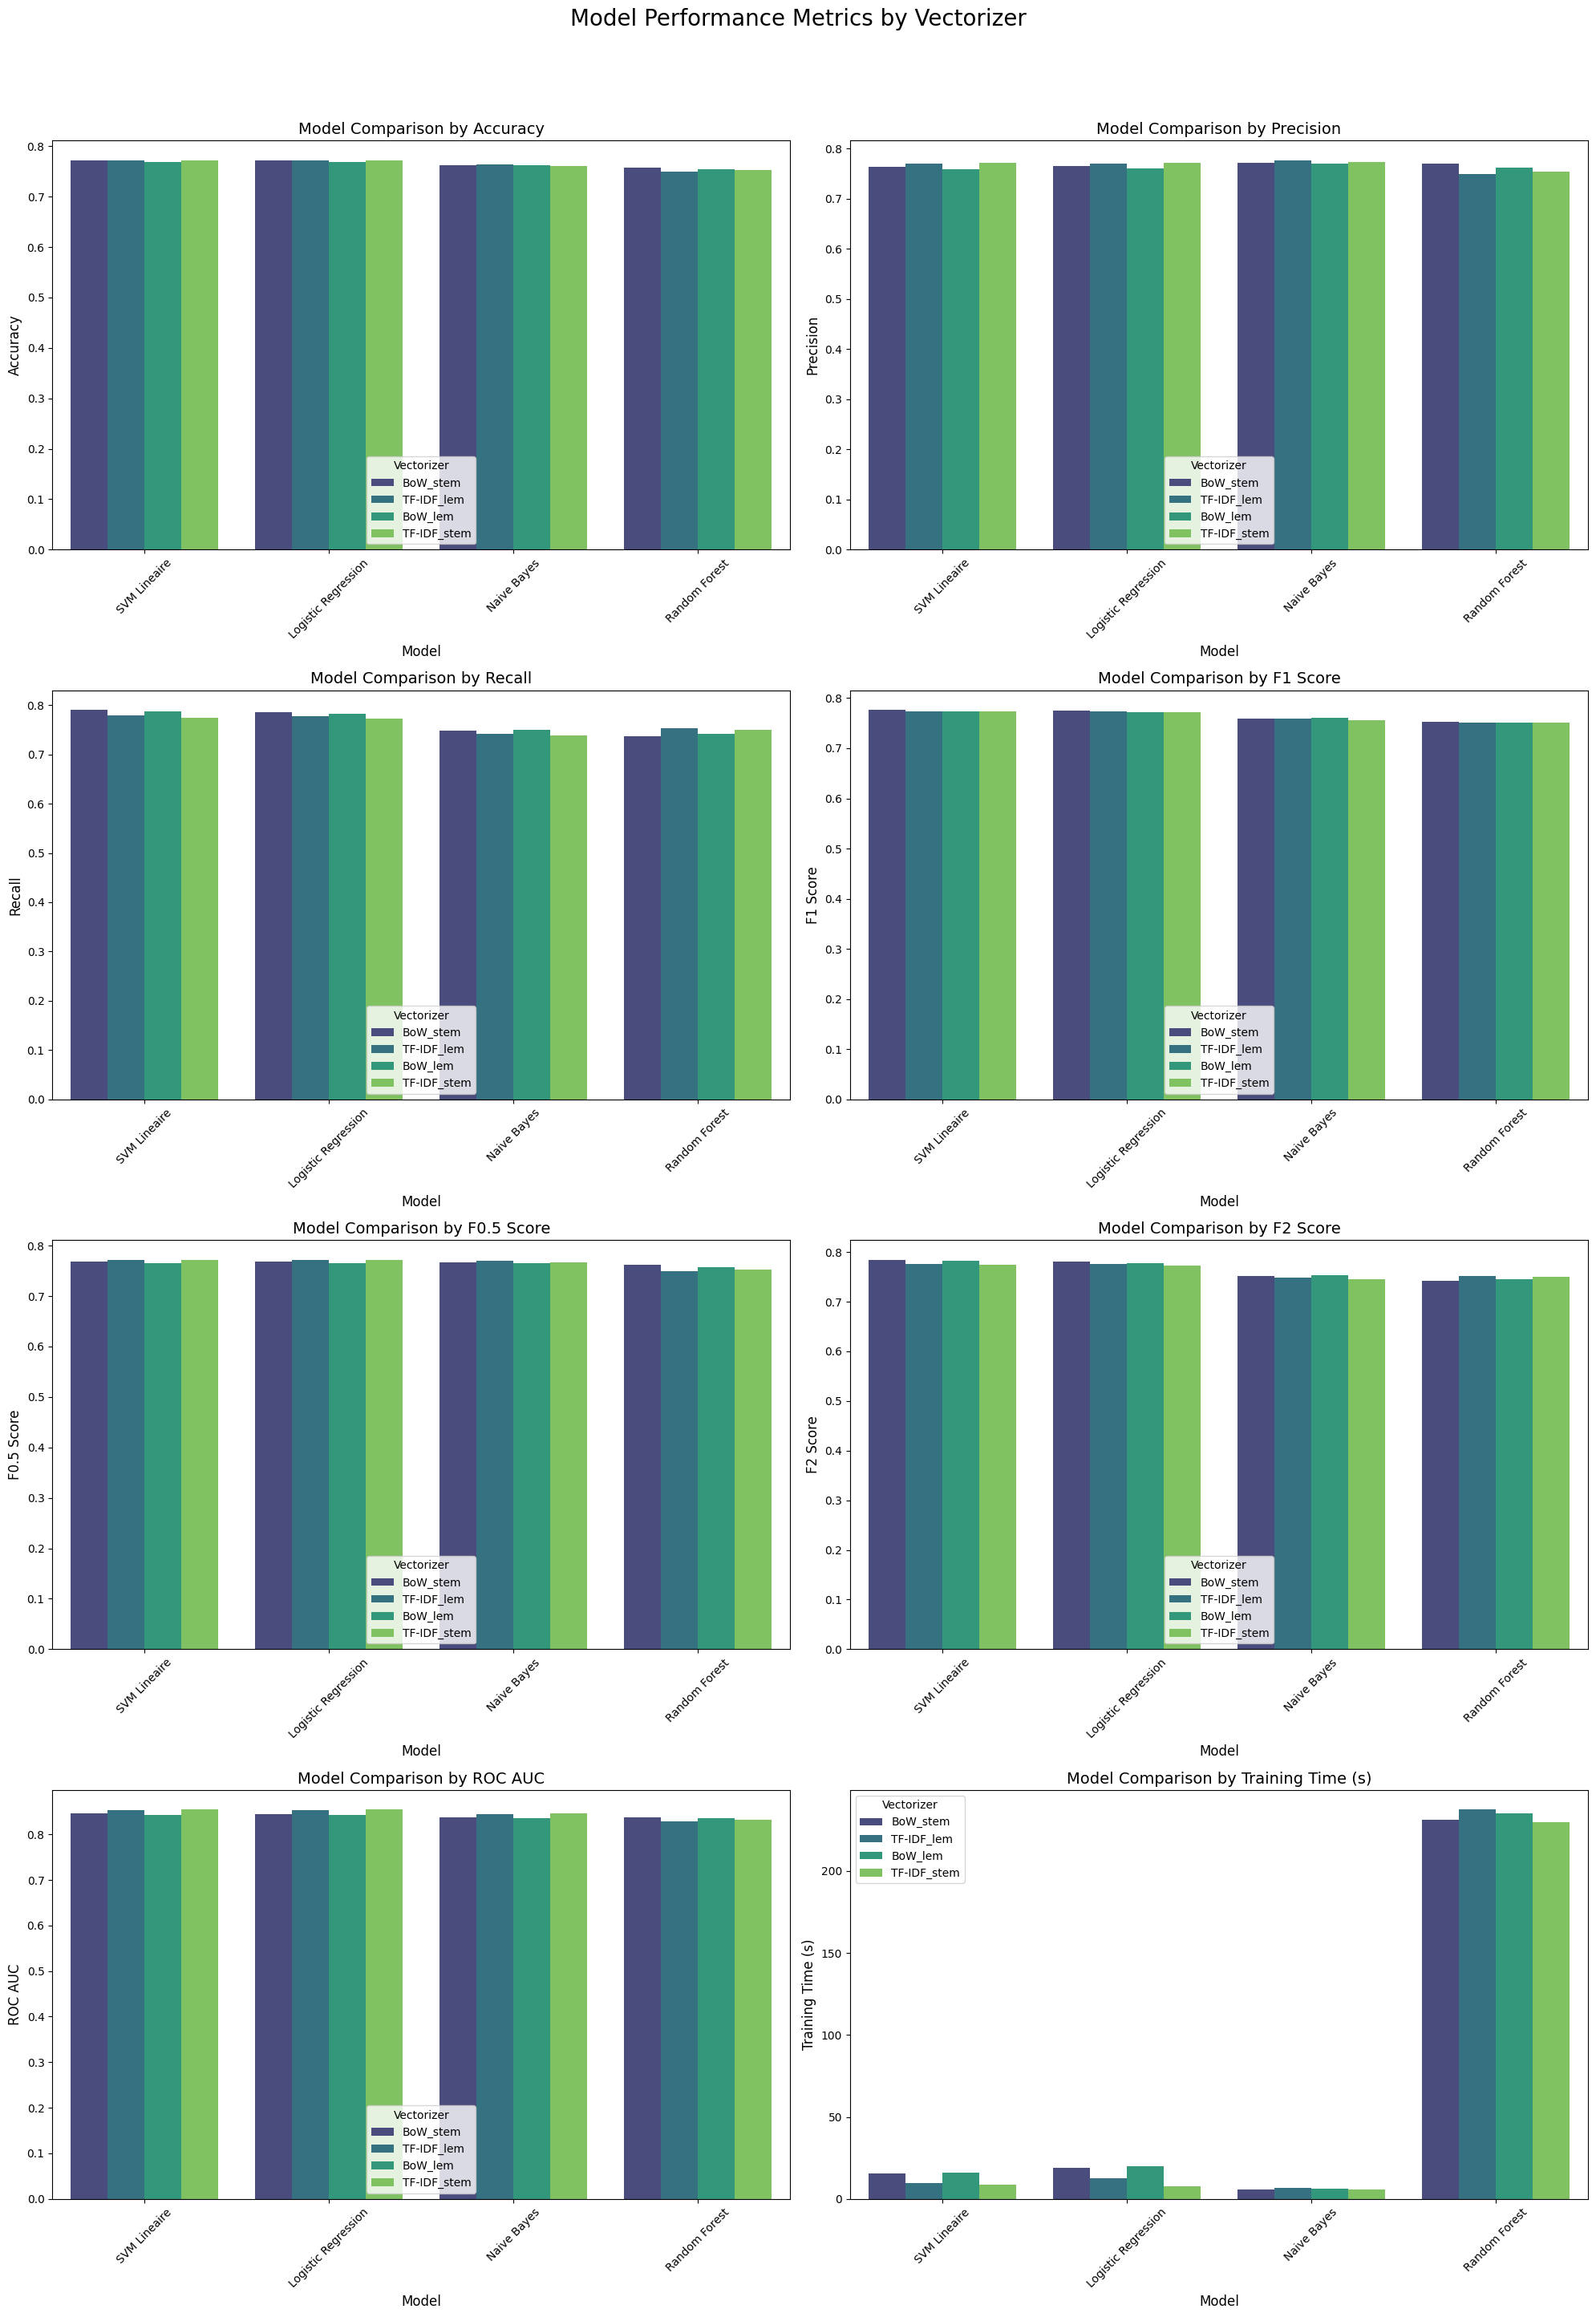

In [ ]:
# Convert metric columns back to numeric for plotting
metric_cols = ["Accuracy", "Precision", "Recall", "Specificity", "ROC AUC", "Training Time (s)"]
for col in metric_cols:
    results_df[col] = pd.to_numeric(results_df[col], errors='coerce')

# Define the metrics to plot
metrics_to_plot = [
    "Accuracy", "Precision", "Recall", "Specificity", "ROC AUC", "Training Time (s)"
]

# Create subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 28))
axes = axes.flatten()

for i, metric in enumerate(metrics_to_plot):
    sns.barplot(data=results_df, x='Model', y=metric, hue='Vectorization', ax=axes[i], palette='viridis')
    axes[i].set_title(f'Model Comparison by {metric}', fontsize=14)
    axes[i].set_xlabel('Model', fontsize=12)
    axes[i].set_ylabel(metric, fontsize=12)
    axes[i].tick_params(axis='x', rotation=45, labelsize=10)
    axes[i].legend(title='Vectorizer')

# Adjust layout to prevent overlap and add a main title
fig.suptitle('Model Performance Metrics by Vectorizer', fontsize=20, y=1.03)
plt.tight_layout()
plt.show()

# Save best model

In [21]:
def load_and_save_model_from_mlflow(experiment_name: str, save_dir: str = "./content/basic-model/best", uri: str = None) -> tuple:
    """
    Loads the best model and its vectorizer from MLflow and saves them locally.

    Args:
        experiment_name (str): The name of the MLflow experiment.
        model_name (str): The name of the model to load.
        vectorizer_name (str): The name of the vectorizer to load.
        save_dir (str): The directory to save the model and vectorizer.
        uri (str): Optional; the URI of the MLflow tracking server. If None, uses the default tracking URI.

    Returns:
        Tuple: The loaded model and vectorizer.
    """
    # Connect to the MLflow tracking server
    if uri:
        mlflow.set_tracking_uri(uri)

    # Create mlflow client
    client = MlflowClient()

    # Get the experiment ID by name
    try:
        experiment = client.get_experiment_by_name(experiment_name)
        if not experiment:
            raise ValueError(f"Experiment '{experiment_name}' not found.")
        experiment_id = experiment.experiment_id
    except Exception as e:
        print(f"Error retrieving experiment '{experiment_name}': {experiment}")
        return

    # Search for the best model run based on F1 score
    model_name = results_df.iloc[0]['Model']
    vectorizer_name = results_df.iloc[0]['Vectorization']
    runs = client.search_runs(experiment_ids=[experiment_id],
                              filter_string=f"tags.mlflow.runName LIKE '%Basic_Model_{model_name.replace(' ', '_')}_{vectorizer_name}%'",
                              order_by=["metrics.f1 DESC"],
                              max_results=1)

    if not runs:
        print(f"No runs found for model '{model_name}' with vectorizer '{vectorizer_name}'.")
        return

    best_run = runs[0]
    run_id = best_run.info.run_id

    # Load the model from MLflow
    model_uri = f"runs:/{run_id}/model"
    model = mlflow.sklearn.load_model(model_uri)

    # Load the vectorizer artifact
    vectorizer_artifact_path = f"vectorizer_{vectorizer_name}.pkl"
    local_vectorizer_path = client.download_artifacts(run_id, vectorizer_artifact_path, dst_path=".")
    with open(local_vectorizer_path, "rb") as f:
        vectorizer = pickle.load(f)

    # Save the model and vectorizer locally
    os.makedirs(save_dir, exist_ok=True)
    model_path = os.path.join(save_dir, "best_model.pkl")
    vectorizer_path = os.path.join(save_dir, f"vectorizer_{vectorizer_name}.pkl")
    with open(model_path, "wb") as f:
        pickle.dump(model, f)
    with open(vectorizer_path, "wb") as f:
        pickle.dump(vectorizer, f)
    print(f"Model and vectorizer saved to '{save_dir}'.")

    return model, vectorizer

In [22]:
# Load and save the best model and vectorizer
best_model, best_vectorizer = load_and_save_model_from_mlflow(
    experiment_name="P7-Sentiments_Analysis",
    save_dir="./content/basic_model/best",
    uri=tracking_uri
)

Model and vectorizer saved to './content/basic_model/best'.


# Test best model

In [23]:
# Automatically retrieve the best vectorizer from the results DataFrame
best_vectorizer_name = results_df.iloc[0]['Vectorization']  # Get the best vectorizer name
vectorizer, X_train_vec, X_test_vec, y_train_vec, y_test_vec = vectorizers[best_vectorizer_name]

# Display the chosen vectorizer and its train-test set shapes
print(f"Chosen vectorizer: {best_vectorizer_name}")
print(f"X_train_vec shape: {X_train_vec.shape}")
print(f"X_test_vec shape: {X_test_vec.shape}")
print(f"y_train_vec shape: {y_train_vec.shape}")
print(f"y_test_vec shape: {y_test_vec.shape}")

Chosen vectorizer: BoW_stem
X_train_vec shape: (40000, 10000)
X_test_vec shape: (10000, 10000)
y_train_vec shape: (40000,)
y_test_vec shape: (10000,)


In [ ]:
# vectorizers = {
#     "TF-IDF_lem": (tfidf_vectorizer, X_train_tfidf_lem, X_test_tfidf_lem, y_train_lem, y_test_lem),
#     "BoW_lem": (bow_vectorizer, X_train_bow_lem, X_test_bow_lem, y_train_lem, y_test_lem),
#     "TF-IDF_stem": (tfidf_vectorizer, X_train_tfidf_stem, X_test_tfidf_stem, y_train_stem, y_test_stem),
#     "BoW_stem": (bow_vectorizer, X_train_bow_stem, X_test_bow_stem, y_train_stem, y_test_stem),
# }
# def get_lem_or_stem(best_vectorizer_name: str, selected_vec: dict) -> tuple:
#     """
#     Determines whether the vectorizer name indicates lemmatization or stemming.
#     Args:
#         best_vectorizer_name (str): The name of the vectorizer.
#         selected_vec (dict): A dictionnary with Bow or Tf-IDF vectorizers
#     Returns:
#         tuple: appropriate X_train and X_test
#     """
#     if 'lem' in best_vectorizer_name:
#         for k, v in selected_vec.items():
#             if 'lem' in k :
#                 final_vec = v
#             elif 'stem' in k :
#                 final_vec = v
#             else :
#                 ValueError()
#         return final_vec[1], final_vec[2]

# def find_train_test_df(best_vectorizer_name: str, vecotrizer_dict: dict = vectorizer) -> tuple:
#     """
#     Determines whether the vectorizer name indicates lemmatization or stemming.
#     Args:
#         best_vectorizer_name (str): The name of the vectorizer.
#     Returns:
#         X_train, X_text (tuple)
#     """
#     if 'BoW' in best_vectorizer_name :
#         selected_vectorizers = {k : v for k,v in vectorizer.items() if 'BoW' in k}
#     elif 'TF-IDF' in best_vectorizer_name :
#         selected_vectorizers = {k : v for k,v in vectorizer.items() if 'TF-IDF' in k}
#     else:
#         ValueError

#     return get_lem_or_stem(vecotrizer_dict, selected_vectorizers)


# X_train, X_test = find_train_test_df(best_vectorizer_name=)

# Get the indices from the original pandas Series (before vectorization)
used_indices = set(X_train_vec.index).union(X_test_vec.index)

# Filter rows not in the train-test dataframes
remaining_data = sample_df.loc[~sample_df.index.isin(used_indices)]

# Pick 10 rows from each target
# Using .groupby().sample() can be slow on large data, but it's fine here.
# Added a check to handle cases where a group might have fewer than 10 samples.
sampled_data = remaining_data.groupby('target').apply(
    lambda x: x.sample(n=min(10, len(x)), random_state=42)
).reset_index(drop=True)

# Display the sampled data
display(sampled_data)

AttributeError: 'csr_matrix' object has no attribute 'index'